In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

from networkx.drawing.nx_pydot import graphviz_layout
import math

First approach : bipartite graph

In [2]:
def f(S, theta):
    """
    input : 
    theta of size V x T
    S of size V : i in S if S[i] == 1
    
    output : 
    expected number of influenced targets
    """
    t1 = np.ones(theta.shape) - theta
    t2 = t1[S, :]
    t3 = np.prod(t2, axis = 0)
    t4 = np.ones(t3.shape) - t3
    return np.sum(t4)
    

In [3]:
nV = 30
nT = 30
pEdge = 0.1

In [4]:
theta_ex = np.random.uniform(0,1,(nV,nT))
mask = np.random.binomial(1,pEdge,(nV,nT))
theta_ex = theta_ex * mask

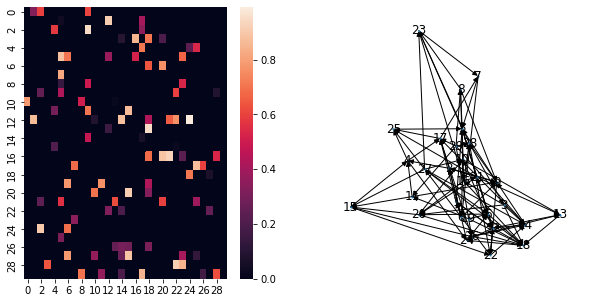

In [15]:
gr = nx.DiGraph(theta_ex)

fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.heatmap(theta_ex, ax= axes[0])
nx.draw(gr, node_size=1, with_labels=True, ax = axes[1])
plt.show()


In [130]:
def standard_greedy(theta, K):
    """
    K = rank of I = number of selected influencers
    """
    nV, nT = theta.shape
    
    S = [] #selected influencers
    U = [v for v in range(nV)] #available influencers
    
    for i in range(K):
        nk = len(U)
        gk = np.array([f(S + [ui], theta) for ui in U])
        
        #pk = argmax(gk)

        #u = np.random.choice(U, 1, pk)[0]
        u = U[np.argmax(gk)]
        U.remove(u)
        S.append(u)
        
    #print("Expected number of influenced : ", f(S, theta))
    return S, f(S, theta)

In [131]:
standard_greedy(theta_ex, 9)

([12, 5, 29, 17, 16, 11, 24, 28, 10], 19.513755888668527)

In [132]:
K = 20

perf_greedy = pd.DataFrame([standard_greedy(theta_ex, k)[1] for k in range(K)])

In [133]:
def softmax(g, axis = 0) :
    g = g-np.max(g)
    t = np.exp(g)
    return t / np.sum(t, axis = axis)

def smoothed_greedy(theta, K, eps):
    """
    K = rank of I = number of selected influencers
    """
    nV, nT = theta.shape
    
    S = [] #selected influencers
    U = list(range(nV)) #available influencers
    
    for i in range(K):
        nk = nV - i
        if U == [] : break
            
        gk = np.array([f(S + [ui], theta) for ui in U])
        pk = list(softmax(gk / eps, axis = 0))
        u = np.random.choice(U, 1, p=pk)[0]
        
        U.remove(u)
        S.append(u)
        
    #print("Expected number of influenced : ", f(S, theta))
    return S, f(S, theta)

In [134]:
n_iter = 30

perf_smoothed = pd.DataFrame()
perf_random = pd.DataFrame()

for i in range(n_iter) :
    perf_smoothed[i] = pd.Series([smoothed_greedy(theta_ex, k, 1)[1] for k in range(K)])
    perf_random[i] = pd.Series([f(np.random.permutation(list(range(K)))[:k], theta_ex) for k in range(K)])
    



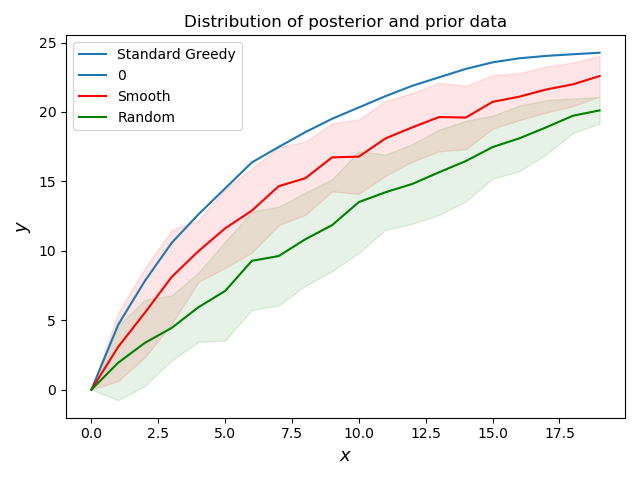

In [135]:
fig, ax = plt.subplots()

sns.lineplot(data = perf_greedy, label = "Standard Greedy", ax = ax)

X = list(range(K))
psAvg = perf_smoothed.mean(axis = 1)
psStd = perf_smoothed.std(axis = 1)

prAvg = perf_random.mean(axis = 1)
prStd = perf_random.std(axis = 1)

ax.plot(X, psAvg, 'r-', label='Smooth')
ax.fill_between(X, psAvg - 2*psStd, psAvg + 2*psStd, color='red', 
                 alpha=0.1)

ax.plot(X, prAvg, 'g-', label='Random')
ax.fill_between(X, prAvg - 2*prStd, prAvg + 2*prStd, color='green', 
                 alpha=0.1)

ax.set_xlabel('$x$', fontsize=13)
ax.set_ylabel('$y$', fontsize=13)
ax.set_title('Comparison of Smoothed and standard greedy algorithm')
ax.legend()
plt.tight_layout()
plt.show()
